## Timeseries analysis in yt_napari 

Similar to loading single datasets, `yt_napari` includes a number of ways to load in timeseries data: the `json` file reader, the napari widget and a jupyter notebook. From a jupyter notebook, you can use `yt_napari.timeseries.add_to_viewer` to specify a set of files to sequentially load and sample and add to an existing `napari.Viewer`. 

This notebook describes:

* `yt_napari.timeseries` Selection objects
* using `yt_napari.timeries.add_to_viewer` to apply a selection to a series of files that you specify and then add those to a `napari.Viewer` instance
* loading timeseries samples as individual layers or a single image stack 
* centering selections

As a preview, here's a video showing the density field in a 15 Mpc wide region from the `enzo_tiny_cosmology` sample yt dataset centered on the location of the maximum density of the final timestep in the series:

![timeseries_intro](./resources/reg_vid_00.gif)


## Quickstart

Before diving into details, the following code blocks load a slice for each timestep of the `enzo_tiny_cosmology` sample dataset and adds it to a napari `Viewer` as a single 3D image stack with dimensions of (timestep, y, z). Note that it will take a bit of time to run the timestep sampling (around 30-60s depending on your machine). 


In [1]:
from yt_napari import timeseries
import yt
import napari 

yt.set_log_level(50) # disable logging to keep notebook output manageable
v = napari.Viewer()

In [2]:
%%capture
s = timeseries.Slice(('enzo', 'Density'), 'x')
timeseries.add_to_viewer(v, s, file_pattern = "enzo_tiny_cosmology/DD????/DD????", 
                         load_as_stack=True, 
                         colormap='magma',
                         name='enzo_tiny_cosmo_density')

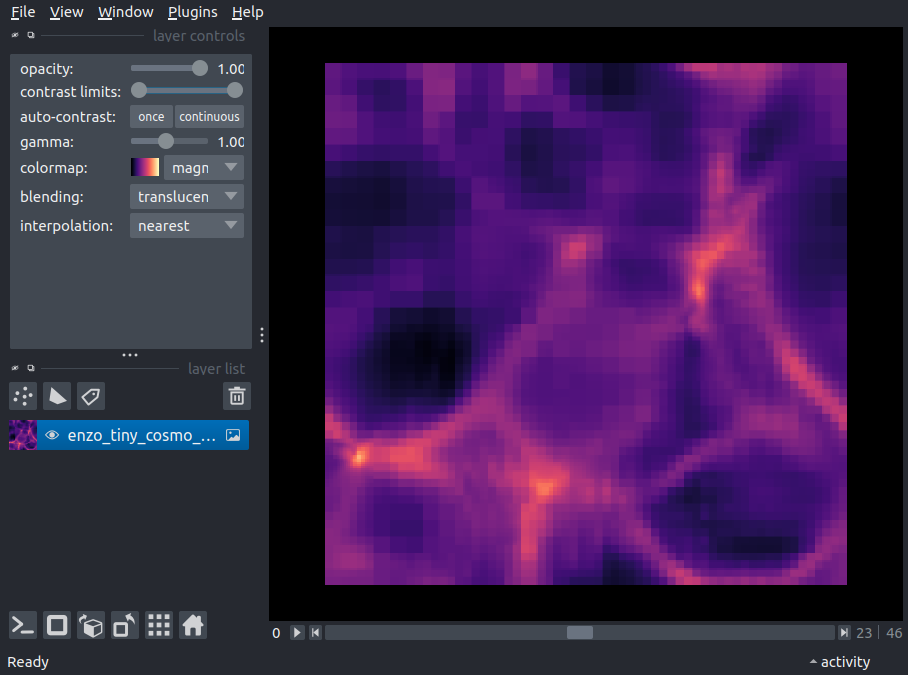

In [3]:
from napari.utils import nbscreenshot
nbscreenshot(v)

The slider beneath the main viewer will let you step through time. 

In [4]:
v.close()

## Detailed Walkthrough 

### Selection objects 

One difference between `yt-napari` and `yt` proper is that when sampling a time series, you first specify a selection object **independently** from a dataset object to define the extents and field of selection. That selection is then applied across all specified timesteps.

The currently available selection objects are a `Slice` or 3D gridded `Region`. The arguments follow the same convention as a usual `yt` dataset selection object (i.e., `ds.slice`, `ds.region`) for specifying the geometric bounds of the selection with the additional constraint that you must specify a single field and the resolution you want to sample at:

In [5]:
from yt_napari import timeseries

In [6]:
timeseries.Slice?

Init signature:
timeseries.Slice(
    field: Tuple[str, str],
    normal: Union[str, int],
    center: Union[unyt.array.unyt_array, Tuple[numpy.ndarray, str], NoneType] = None,
    width: Union[unyt.array.unyt_quantity, Tuple[float, str], NoneType] = None,
    height: Union[unyt.array.unyt_quantity, Tuple[float, str], NoneType] = None,
    resolution: Optional[Tuple[int, int]] = (400, 400),
    periodic: Optional[bool] = False,
    take_log: Optional[bool] = None,
)
Docstring:     
A 2D axis-normal slice through a domain.

Parameters
----------
field: (str, str)
    a yt field present in all timeseries to load.
normal: int or str
    the normal axis for slicing
center: unyt_array
    (optional) a 3-element unyt_array defining the slice center, defaults
    to the domain center of each active timestep.
width: unyt_quantity or (value, unit)
    (optional) the slice width, defaults to the domain width  of each active
    timestep.
height: unyt_quantity or (value, unit)
    (optional) the 

In [7]:
timeseries.Region?

Init signature:
timeseries.Region(
    field: Tuple[str, str],
    left_edge: Union[unyt.array.unyt_array, Tuple[numpy.ndarray, str], NoneType] = None,
    right_edge: Union[unyt.array.unyt_array, Tuple[numpy.ndarray, str], NoneType] = None,
    resolution: Optional[Tuple[int, int, int]] = (400, 400, 400),
    take_log: Optional[bool] = None,
)
Docstring:     
A 3D rectangular selection through a domain.

Parameters
----------
field: (str, str)
    a yt field present in all timeseries to load.
left_edge: unyt_array or (ndarray, str)
    (optional) a 3-element unyt_array defining the left edge of the region,
    defaults to the domain left_edge of each active timestep.
right_edge: unyt_array or (ndarray, str)
    (optional) a 3-element unyt_array defining the right edge of the region,
    defaults to the domain right_edge of each active timestep.
resolution: (int, int, int)
    (optional) 3-element tuple defining the resolution to sample at. Default
    is (400, 400, 400).
take_log: boo

Once you create a `Slice` or `Region`, you can pass that to `add_to_viewer` and it will be used to sample each timestep specified. 

## Slices through a timeseries

The simplest case is when you want to extract the same 2D slice through a timeseries. 

To start, let's initialize a `napari` viewer:

In [8]:
import napari 

In [9]:
v = napari.Viewer()

and let's build the `Slice` object that will get applied to each timestep. To do so, you need to at least specify the field to sample and the normal axis for the slice:

In [10]:
s = timeseries.Slice(('enzo', 'Density'), 'x')                   

### adding a timeseries to a viewer (`add_to_viewer`)

From here, you pass the viewer and selection object to `timeseries.add_to_viewer` along with some options for specifying what files to load and some parameters controlling how the data is eventually loaded:

In [11]:
timeseries.add_to_viewer?

Signature:
timeseries.add_to_viewer(
    viewer: napari.viewer.Viewer,
    selection: Union[yt_napari.timeseries.Slice, yt_napari.timeseries.Region],
    file_dir: Optional[str] = None,
    file_pattern: Optional[str] = None,
    file_list: Optional[List[str]] = None,
    file_range: Optional[Tuple[int, int, int]] = None,
    load_as_stack: Optional[bool] = False,
    use_dask: Optional[bool] = False,
    return_delayed: Optional[bool] = True,
    stack_scaling: Optional[float] = 1.0,
    **kwargs,
)
Docstring:
Sample a timeseries and add to a napari viewer

Parameters
----------
viewer: napari.Viewer
    a napari Viewer instance
selection: Slice or Region
    the selection to apply to each matched dataset
file_dir: str
    (optional) a file directory to prepend to either the file_pattern or
    file_list argument.
file_pattern: str
    (optional) a file pattern to match, not used if file_list is set. One of
    file_pattern or file_list must be set.
file_list: str
    (optional) a lis

### specifying the datasets 

Similar to the `yt` `DataSeries` object, you can specify the files corresponding to the timesteps of interest in a number of ways:

* file_pattern : a glob pattern string to identify files, e.g., `"DD????/DD????"`. 
* file_list: an explicit list of files 

Additionally, if you specify `file_dir`, then both the `file_pattern` and `file_list` arguments will be joined to `file_dir` so that you can specify, for example,

```python
timeseries.add_to_viewer(v, s, file_list=["file_1", "file_2", ...], file_dir='my/datset/dir')
```
rather than `file_list=["my/datset/dir/file_1", "my/datset/dir/file_2", ...]`. 

If a file is not found in your current path, it will check the yt `test_data_dir` configuration directory.


**Finally**, you can also use the `file_range` parameter to limit the datasets picked up by `file_pattern` matches. The `file_range` parameter is a 3-element tuple representing a selection range with (start, end, step) so that you can, for example, select every 5th dataset matched by the `file_pattern`. 

### loading as a stack
So we're now ready to load our timeseries! If you just call `add_to_viewer`, each timestep will be added as a separate layer in napari. Since we're loading 47 timesteps here, we'll also supply the `load_as_stack=True` parameter so that the slices get added as a single image array:

In [12]:
file_pattern = "enzo_tiny_cosmology/DD????/DD????"

In [13]:
%%time
%%capture
yt.set_log_level(40)
timeseries.add_to_viewer(v,s,file_pattern=file_pattern, load_as_stack=True, colormap='magma');

CPU times: user 32.8 s, sys: 492 ms, total: 33.3 s
Wall time: 33.3 s


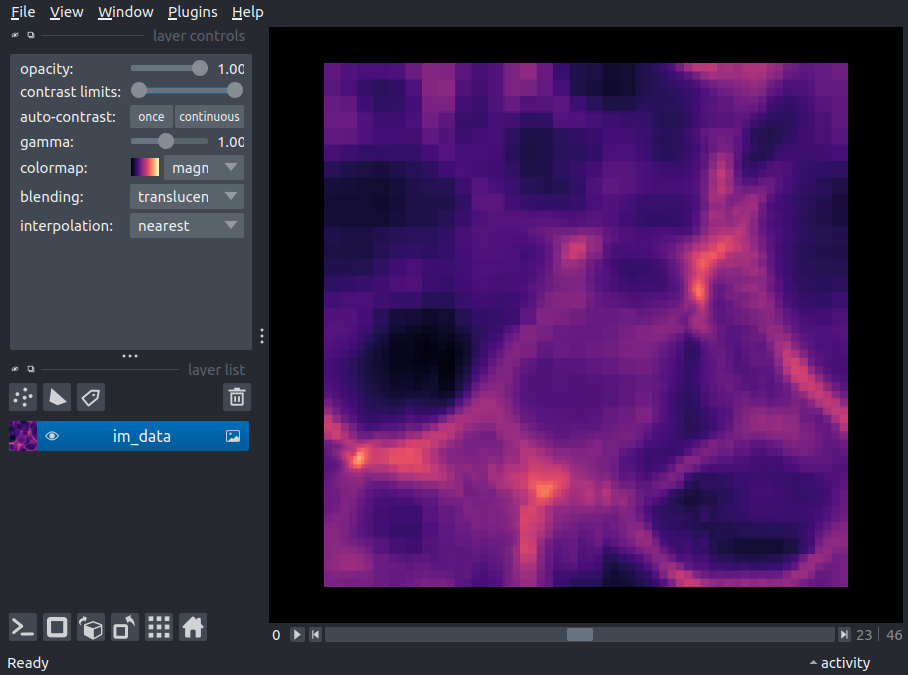

In [14]:
nbscreenshot(v)

### loading a range of matches 

In the case above, we are loading in 47 timesteps. We can also specify a `file_range` tuple in the form of `(start, stop, step)`, and the identified files will be subsampled from the full range of matched files. To extract every 10th, for example:


In [15]:
%%time
%%capture
v.layers.clear()
timeseries.add_to_viewer(v,s,file_pattern=file_pattern, file_range=(0, 50, 10), load_as_stack=True, colormap='magma');

CPU times: user 3.75 s, sys: 272 ms, total: 4.02 s
Wall time: 3.57 s


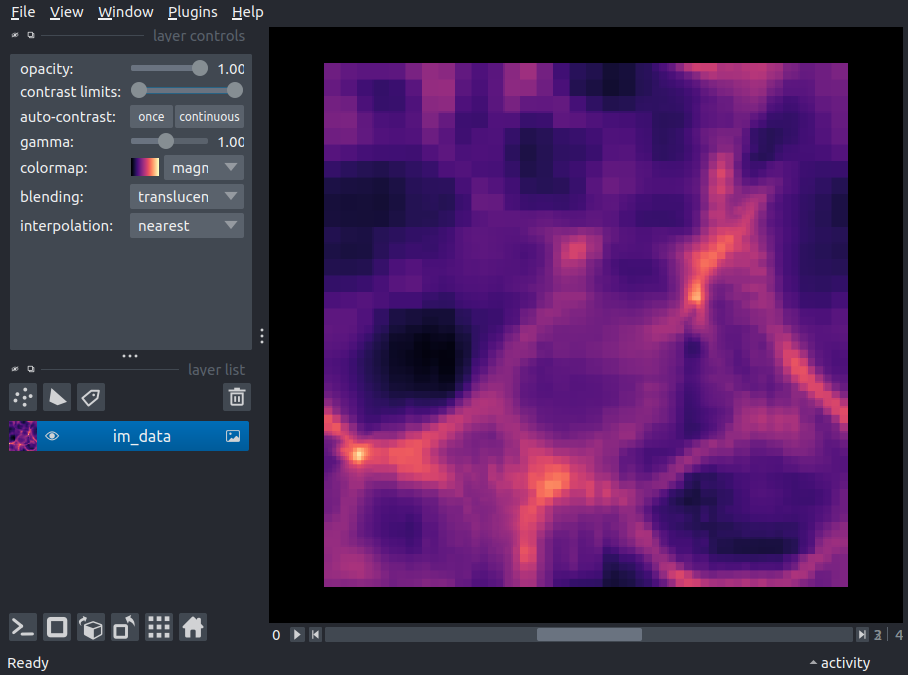

In [16]:
nbscreenshot(v)

### loading specific timesteps 

And finally, you can specify the exact files you want with `file_list`. If you also provide a `file_dir`, it will get pre-prended to the filenames in `file_list` to save you some typing. In this case, since only 3 timesteps are specified, we can omit the `load_as_stack` argument to instead load them as separate layers:

In [17]:
%%time
%%capture
v.layers.clear()
flist = ["DD0024/DD0024", "DD0034/DD0034", "DD0041/DD0041"]
timeseries.add_to_viewer(v, s, file_dir="enzo_tiny_cosmology", file_list=flist, 
                         contrast_limits=(-1, 2), colormap='magma');

CPU times: user 2.4 s, sys: 312 ms, total: 2.72 s
Wall time: 2.2 s


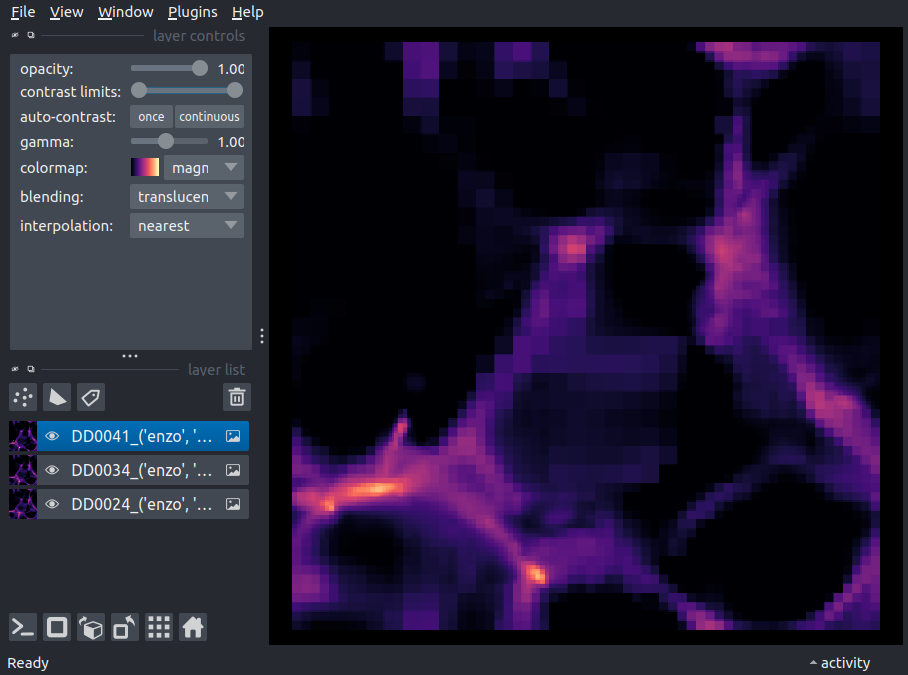

In [18]:
nbscreenshot(v)

## Sampling a Region through a timeseries

The `yt_napari.timeseires.Region` selection object behaves much the same way. The `field` is the only required argument, with default bounds being taken from the full domain of each timestep loaded in (note that if the bounds of your simulation change over time you should specify edge values to load in). 

**Importantly**, you have to be careful loading in regions as it's very easy to exceed the available memory on your machine. The next notebook describes how to leverage dask for lazy loading of timeseries samples, but for now we'll just load in a small subset of timesteps. 


In [19]:
reg = timeseries.Region(("enzo", "Temperature"))

now when we supply `load_as_stack`, our 3D arrays will become 4D arrays!

In [20]:
%%time
%%capture
v.layers.clear()
flist = ["DD0024/DD0024", "DD0034/DD0034", "DD0041/DD0041"]
timeseries.add_to_viewer(v, reg, file_dir="enzo_tiny_cosmology", file_list=flist, 
                         colormap='magma', load_as_stack=True, name="Temp_series");

CPU times: user 4.98 s, sys: 1.06 s, total: 6.04 s
Wall time: 5.56 s


In [21]:
v.dims.ndisplay=3
v.camera.angles = (15, 15, 75)
v.camera.zoom = 1

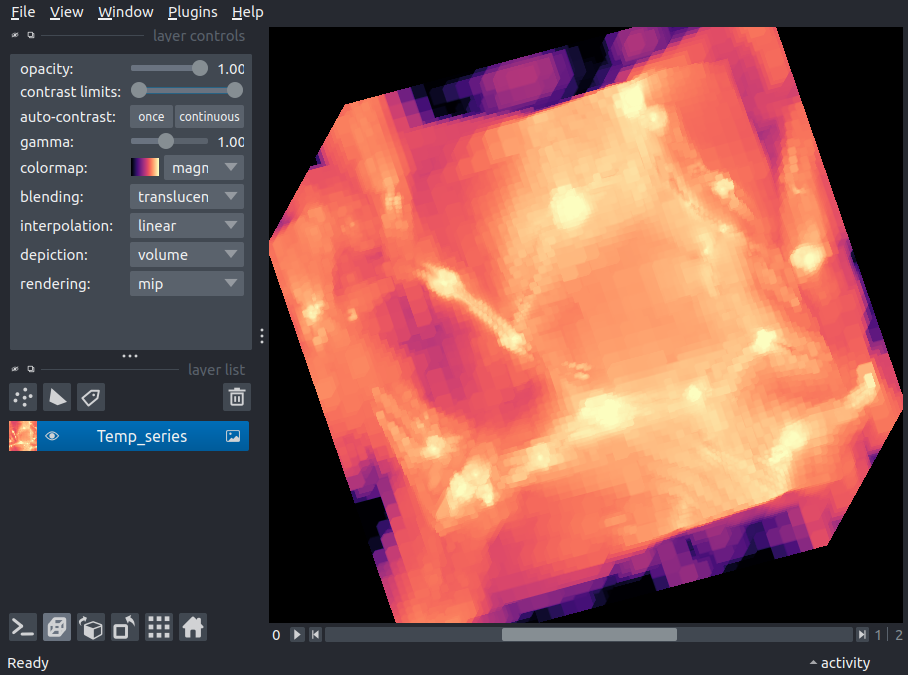

In [22]:
nbscreenshot(v)

The slider beneath the viewer will let you step through time.

## Positioning your selections 

The `Slice` and `Region` objects do not have any of `yt`'s helpful automatic centering functionality implemented at present. So if, for example, you want to center your `Region` on the maximum density of the final timestep, you'll want to first load in that timestep and find the position of the max value then use that to build your `Region`. 

The following walks through such an example. 

First, load in a single timestep as a standard `yt` dataset: 

In [23]:
ds = yt.load("enzo_tiny_cosmology/DD0046/DD0046")

and then find the location of the maximum density value:

In [24]:
ad = ds.all_data()
max_dens = ad.quantities.max_location(("enzo", "Density"))
max_dens

Parsing Hierarchy : 100%|███████████████████| 211/211 [00:00<00:00, 9782.66it/s]


[unyt_quantity(101654.2578125, 'code_mass/code_length**3'),
 unyt_quantity(0.55517578, 'code_length'),
 unyt_quantity(0.66357422, 'code_length'),
 unyt_quantity(0.85888672, 'code_length')]

and store the max location as an array to use later:

In [25]:
reg_c = ds.arr(max_dens[1:], 'code_length')
reg_c

unyt_array([0.55517578, 0.66357422, 0.85888672], 'code_length')

### centered Slice

Now we can build a slice centered on the above array and sample that slice through the timeseries:

In [26]:
wid = ds.quan(15, 'Mpc')

In [27]:
slc = timeseries.Slice(("enzo", "Density"), "x", center=reg_c, width=wid, height=wid, resolution=(400, 400))

In [28]:
%%time
%%capture
v.layers.clear()
file_pattern = "enzo_tiny_cosmology/DD????/DD????"
timeseries.add_to_viewer(v, slc, file_pattern=file_pattern, 
                         colormap='magma', load_as_stack=True, name="Density_slice_series");

CPU times: user 33.1 s, sys: 513 ms, total: 33.6 s
Wall time: 33.1 s


The following is a video of stepping through the timeseries:

![max-centered timeseries slice](./resources/slice_vid_00.gif)

### centered Region

In order to be able to sample all of the timesteps in memory, the following sets a fairly low resolution 3D sample. We'll reuse the center location and calculate a left and right edge releative to that center:

In [29]:
hwid = wid/2.
le = reg_c - hwid
re = reg_c + hwid
le, re
reg = timeseries.Region(("enzo", "Density"), left_edge=le, right_edge=re, 
                        resolution=(50, 50, 50))

In [30]:
%%time
%%capture
v.layers.clear()
file_pattern = "enzo_tiny_cosmology/DD????/DD????"
timeseries.add_to_viewer(v, reg, file_pattern=file_pattern, 
                         colormap='magma', load_as_stack=True, name="Density_series");

CPU times: user 33.3 s, sys: 522 ms, total: 33.8 s
Wall time: 33.2 s


In [31]:
v.dims.ndisplay=3

and a resulting screenshot: 

![max-centered timeseries region](./resources/reg_vid_00.gif)

## A note on spatial scales and unit registries

In the previous two examples, we directly used the unyt array for the location of the max density (`reg_c` above) from one of our datasets. This particular simulation is a cosmological simulation in which the bounds of the domain actually change with time depending on what length unit you look at. In physical distance, `ds.domain_width('Mpc')` increases throughout the simulation. The co-moving distance, however, does not (`ds.domain_width('Mpccm')` is fixed through time). 

So depending on how you provide arguments to the `Slice` and `Region` objects, you can end up with different behaviors. 

In the previous `Slice` example, by provding both a center and width argument, the spatial extents of the slice are calculated immediately, so the extents of the slice will evaluate to:

In [47]:
wid = ds.quan(15, 'Mpc')
reg_c[1:] - wid/2, reg_c[1:] + wid/2

(unyt_array([0.49904297, 0.69435547], 'code_length'),
 unyt_array([0.82810547, 1.02341797], 'code_length'))

so that for each time step, that `code_length` range is sampled and we are effectively supplying our slice extents in co-moving coordinates. 

If we instead specify the center and width as 

In [54]:
c = (reg_c.d, 'code_length')
wid = (15, 'Mpc')

then for each time step, the slice will still be centered on the same co-moving coordinate location, but the extent of the slice will be re-calculate at each timestep, resulting in a slice extent that varies by timestep. Because the early steps of the simulation are much less than 15 Mpc wide, this results in a slice that grows in time:

In [42]:
slc = timeseries.Slice(("enzo", "Density"), "x", center=c, width=wid, height=wid, resolution=(400, 400))

In [49]:
%%time
%%capture
v.layers.clear()
file_pattern = "enzo_tiny_cosmology/DD????/DD????"
timeseries.add_to_viewer(v, slc, file_pattern=file_pattern, 
                         colormap='magma', load_as_stack=True, name="Density_slice_series", 
                         stack_scaling = 5.0
                         );

CPU times: user 33.4 s, sys: 599 ms, total: 34 s
Wall time: 34.7 s


The following video shows how the slice now changes through time. In the final parts of the video, the viewer dimensionality is changed to 3D, resulting in a 2D spatial + 1D time view in which the time axis scaling is controlled by the above `stack_scaling` parameter. 

![max-centered slice co-moving](resources/reg_vid_01_physical.gif)

You can recover the original behavior by instead specifying the width in co-moving distance:

In [50]:
c = (reg_c.d, 'code_length')
wid = (15, 'Mpccm')
slc = timeseries.Slice(("enzo", "Density"), "x", center=c, width=wid, height=wid, resolution=(400, 400))

In [52]:
v = napari.Viewer()

In [53]:
%%time
%%capture
v.layers.clear()
file_pattern = "enzo_tiny_cosmology/DD????/DD????"
timeseries.add_to_viewer(v, slc, file_pattern=file_pattern, 
                         colormap='magma', load_as_stack=True, name="Density_slice_series", 
                         stack_scaling = 5.0
                         );

CPU times: user 33.7 s, sys: 478 ms, total: 34.2 s
Wall time: 34.4 s


## A  note on high resolution samples and larger-than memory arrays

Loading in 3D regions at higher resolutions can quickly exceed the available memory on your machine if you load more than a few timesteps. To handle those cases, you can lazily load data with the `use_dask` parameter of `timeseries.add_to_viewer()`. The next notebook walks through its usage.